# GRU4Rec

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import pandas as pd
import numpy as np
from recs.evaluator import evaluate
from recs import utils
from recs.jaxmodels import GRU4Rec, GRU4RecConfig
from recs.dataset import session_parallel_dataset

import optax
from flax.training import train_state
from flax.training import common_utils
from flax import linen as nn

import tensorflow as tf
from tqdm.notebook import tqdm

import jax
from jax import numpy as jnp

In [3]:
data = pd.read_pickle("~/work/dataset/RC15/derived/train.df")
test_data = pd.read_pickle("~/work/dataset/RC15/derived/test.df")

In [4]:
train_data, total_length = session_parallel_dataset(batch_size = 500)

In [5]:
num_items = max(data.itemId.max(), test_data.itemId.max()) + 1

In [6]:
def create_train_state(key, config):
    model = GRU4Rec(config)
    hidden = model.init_hidden(config.batch_size, config.hidden_size, config.num_layers)
    params = model.init(key, jnp.ones((config.batch_size,), dtype=jnp.float32), hidden)["params"]
    tx = optax.adagrad(config.learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx), hidden, model

In [9]:
@jax.jit
def train_step(state, x, y, mask, hidden):
    mask = jnp.expand_dims(mask, axis=-1)
    hidden = mask * hidden
    def loss_fn(params, hidden):
        logits, hidden = model.apply({"params":params}, x, hidden)
        logit_sampled = logits[:, y.reshape(-1)]
        one_hot_labels = jax.nn.one_hot(jnp.arange(y.shape[0]), num_classes=y.shape[0])
        loss = -jnp.mean(one_hot_labels * logit_sampled)
        return loss, hidden
    (loss, hidden), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, hidden)
    state = state.apply_gradients(grads=grads)
    return state, loss, hidden

In [15]:
config = GRU4RecConfig(
    hidden_size=100, 
    output_size=num_items, 
    batch_size=500, 
    dropout_hidden=0., 
    learning_rate=0.01, 
    momentum=0.,
    final_act="log_softmax"
)
num_epochs = 100
state, hidden, model = create_train_state(jax.random.PRNGKey(1), config)

before_loss = np.inf
stop_count = 0
for epoch in range(num_epochs):
    batch_loss = 0.
    with tqdm(enumerate(train_data.as_numpy_iterator()), desc="[Epoch %d] training"%epoch, total=total_length) as ts:
        for i, batch in ts:
            batch = common_utils.shard(batch)
            inputs, targets, masks = batch["input"], batch["target"], batch["mask"]
            state, loss, hidden = train_step(state, inputs, targets, masks, hidden)
            batch_loss += loss
            ts.set_postfix(OrderedDict(loss=batch_loss/(i + 1)))
            
    if before_loss > batch_loss:
        before_loss = batch_loss
    else:
        stop_count += 1
    
    if stop_count > 3:
        break

[Epoch 0] training:   0%|          | 0/47456 [00:00<?, ?it/s]

[Epoch 1] training:   0%|          | 0/47456 [00:00<?, ?it/s]

[Epoch 2] training:   0%|          | 0/47456 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [16]:
test_data, test_len = session_parallel_dataset(path="~/work/dataset/RC15/derived/test.df", batch_size=500)

In [ ]:
k =20
 
hidden = model.init_hidden(config.batch_size, config.hidden_size, config.num_layers)
recalls, mrrs = [], []
for i, batch in tqdm(enumerate(test_data.as_numpy_iterator()), desc="evaluating", total=test_len):
    batch = common_utils.shard(batch)
    inputs, targets, masks = jnp.squeeze(batch["input"]), jnp.squeeze(batch["target"]), jnp.squeeze(batch["mask"])
    masks = jnp.expand_dims(masks, axis=-1)
    hidden = masks * hidden
    logits, hidden = jax.jit(model.apply)({"params":state.params}, inputs, hidden)
    
    _, indices = jax.lax.top_k(logits, k=k)
    targets = jnp.expand_dims(targets, axis=-1)
    
    mrr = jnp.reciprocal((indices == targets).nonzero()[1] + 1)
    mrrs += [np.asarray(jnp.sum(mrr) / targets.shape[0])]
    
    recall = jnp.sum(indices == targets) / targets.shape[0]
    recalls += [np.asarray(recall)]

evaluating:   0%|          | 0/11861 [00:00<?, ?it/s]

In [18]:
np.mean(recalls), np.mean(mrrs)

(0.00052450446, 9.2177936e-05)

In [15]:
recalls = np.stack(recalls)
mrrs = np.stack(mrrs)
np.mean(recalls), np.std(recalls)

(0.011284523, 0.028880699)

In [16]:
recalls.shape

(11855,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f28f838fac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f28f83ab160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f28f8384670>],
 'medians': [<matplotlib.lines.Line2D at 0x7f28f83ab640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f28f83ab910>],
 'means': []}

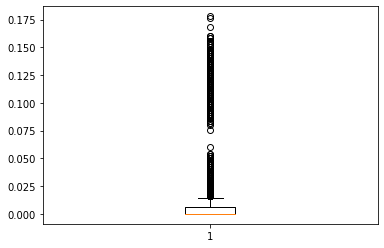

In [17]:
import matplotlib.pyplot as plt
plt.boxplot(recalls)

# Popularityモデル

In [4]:
class Pop:
    
    def __init__(self, top_n = 100, item_key = 'itemId', support_by_key = None):
        self.top_n = top_n
        self.item_key = item_key
        self.support_by_key = support_by_key
    
    def fit(self, data):
        grp = data.groupby(self.item_key)
        self.pop_list = grp.size() if self.support_by_key is None else grp[self.support_by_key].nunique()
        self.pop_list = self.pop_list / (self.pop_list + 1)
        self.pop_list.sort_values(ascending=False, inplace=True)
        self.pop_list = self.pop_list.head(self.top_n)  
    
    def predict_next(self, session_id, input_item_id, predict_for_item_ids):

        preds = np.zeros(len(predict_for_item_ids))
        mask = np.in1d(predict_for_item_ids, self.pop_list.index)
        preds[mask] = self.pop_list[predict_for_item_ids[mask]]
        return pd.Series(data=preds, index=predict_for_item_ids)

In [5]:
pop_model = Pop(top_n=20)
pop_model.fit(data)

In [8]:
test_sess = test_data.groupby("sessionId")["itemId"].unique().reset_index()

In [9]:
predict_for_item_ids = data["itemId"].unique()

In [ ]:
test_sess["pred_items"] = test_sess["sessionId"].apply(lambda x: pop_model.predict_next(x, 0, predict_for_item_ids).sort_values().tail(20).index)

In [ ]:
test_sess

In [28]:
import joblib

In [29]:
calc_recall = lambda x: len(set(pop_model.predict_next(x, 0, predict_for_item_ids).sort_values().tail(20).index) & set(test_sess[test_sess["sessionId"] == x]["itemId"].values[0])) / len(test_sess[test_sess["sessionId"] == x]["itemId"].values[0]) 

In [32]:
recalls = [calc_recall(x) for x in tqdm(test_sess["sessionId"].unique())]

  0%|          | 0/1995220 [00:00<?, ?it/s]

In [33]:
np.mean(recalls)

0.044196720948628046

In [21]:
test_sess[test_sess["sessionId"] == x]["itemId"].values[0]

array([27574, 28208])